In [ ]:
import numpy as np
from scipy.stats import poisson, binom, geom, norm

def galton_watson_extinction(Y_v, m, N=10000, max_generations=50):
    """
    Simulate extinction probabilities for a Galton-Watson process.
    
    Parameters:
        Y_v (str): Offspring distribution ('poisson', 'binomial', 'geometric').
        m (float): Mean offspring count.
        N (int): Number of simulations.
        max_generations (int): Maximum generations to simulate.
    
    Returns:
        qi (list): Extinction probabilities for each generation.
        q (float): Overall extinction probability.
        ci (list): Confidence intervals for each qi.
    """
    def sample_offspring(Y_v, m):
        if Y_v == "poisson":
            return np.random.poisson(m)
        elif Y_v == "binomial":
            return np.random.binomial(10, m / 10)
        elif Y_v == "geometric":
            return np.random.geometric(1 / m) - 1  # Zero-indexed
        else:
            raise ValueError("Unsupported offspring distribution")
    
    extinction_counts = np.zeros(max_generations)
    
    for _ in range(N):
        Z = 1  # Start with one ancestor
        for gen in range(max_generations):
            if Z == 0:
                extinction_counts[gen:] += 1
                break
            Z = sum(sample_offspring(Y_v, m) for _ in range(Z))
    
    # Estimate q_i and q
    qi = extinction_counts / N
    q = qi[-1]
    
    # Compute confidence intervals
    z = norm.ppf(0.975)  # 95% CI
    ci = [
        (q_gen - z * np.sqrt(q_gen * (1 - q_gen) / N),
         q_gen + z * np.sqrt(q_gen * (1 - q_gen) / N)) 
        for q_gen in qi
    ]
    
    return qi, q, ci

# Example usage
Y_v_list = ["poisson", "binomial", "geometric"]
m_values = [1.05, 1.1]

for Y_v in Y_v_list:
    for m in m_values:
        print(f"Distribution: {Y_v}, m: {m}")
        qi, q, ci = galton_watson_extinction(Y_v, m, N=10000, max_generations=50)
        print(f"q_i: {qi}")
        print(f"q: {q}")
        print(f"CI: {ci[-1]} (final generation)\n")


Simulating: Distribution=poisson, m=1.05
q (Overall Extinction Probability): 0.8991
CI for q: (0.8931966616848453, 0.9050033383151547)


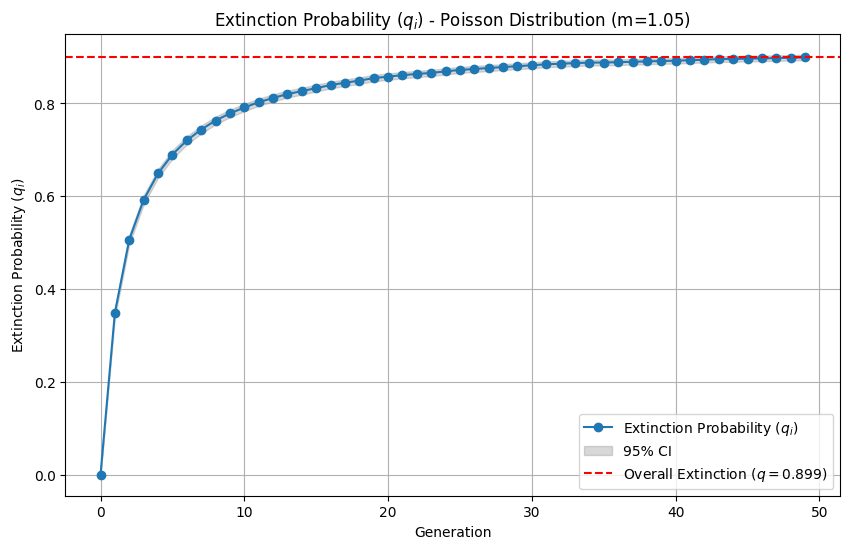

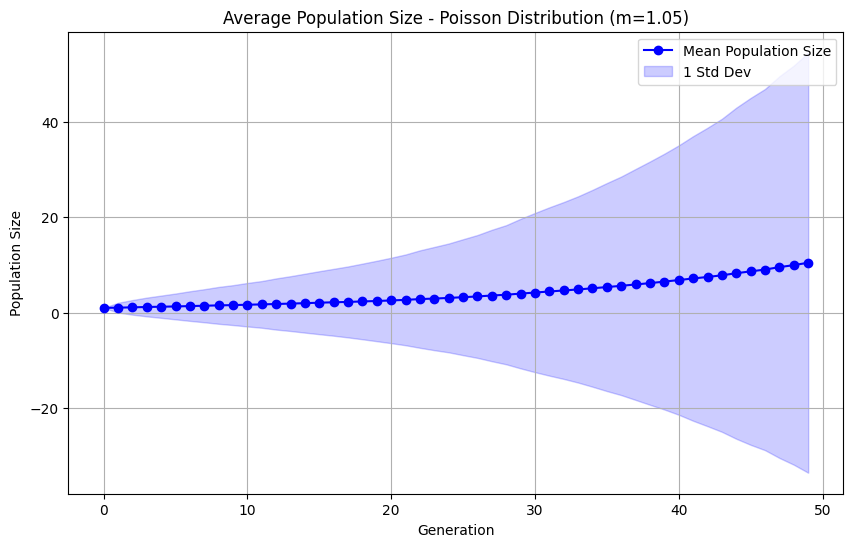

Simulating: Distribution=poisson, m=1.1
q (Overall Extinction Probability): 0.822
CI for q: (0.8145028879639644, 0.8294971120360355)


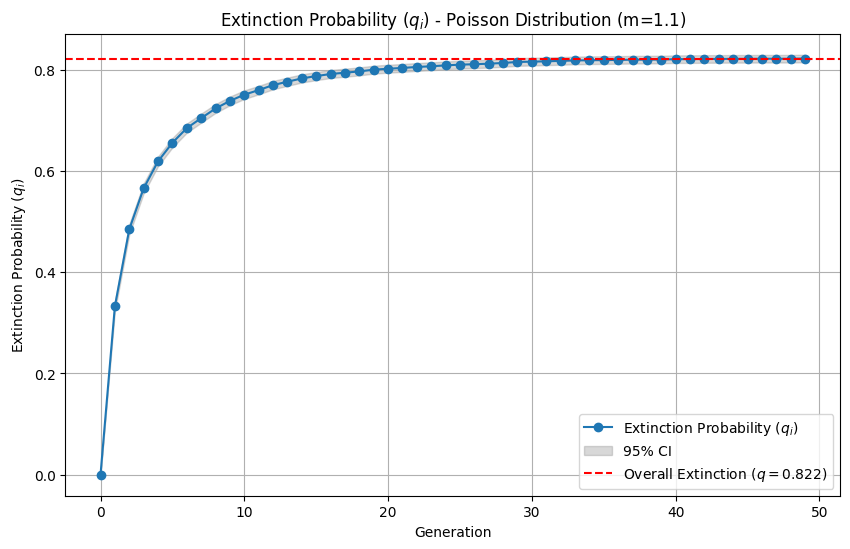

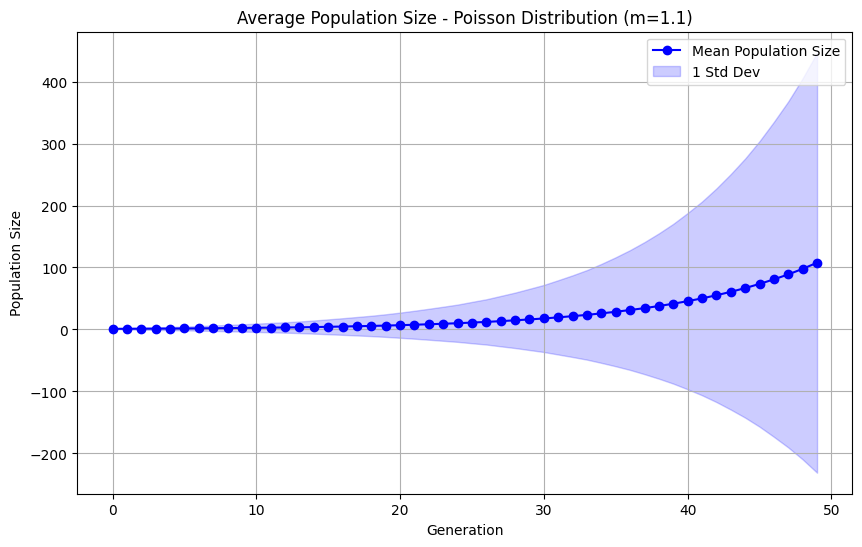

Simulating: Distribution=binomial, m=1.05
q (Overall Extinction Probability): 0.893
CI for q: (0.8869414916705831, 0.8990585083294169)


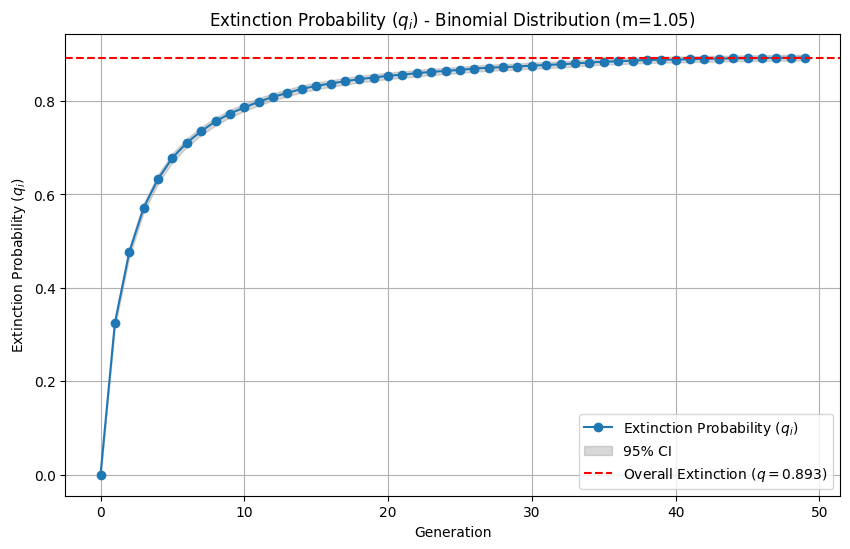

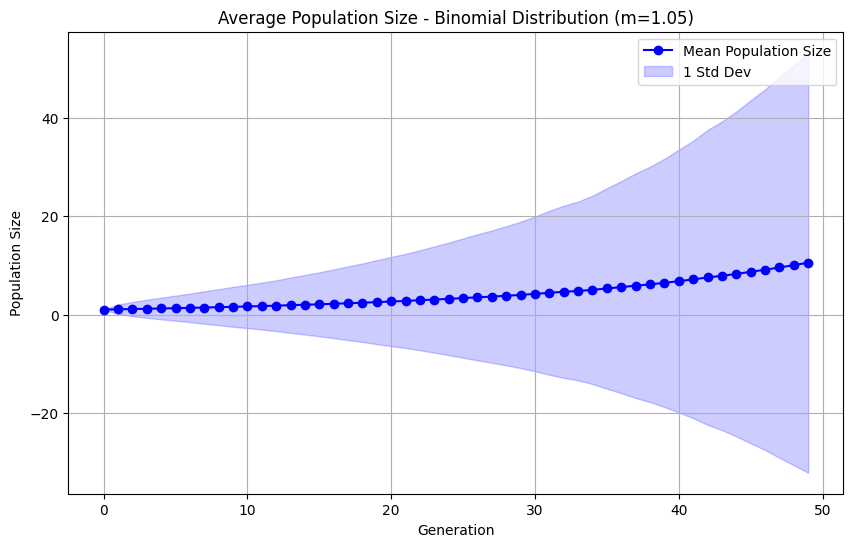

Simulating: Distribution=binomial, m=1.1
q (Overall Extinction Probability): 0.7984
CI for q: (0.7905367221997163, 0.8062632778002837)


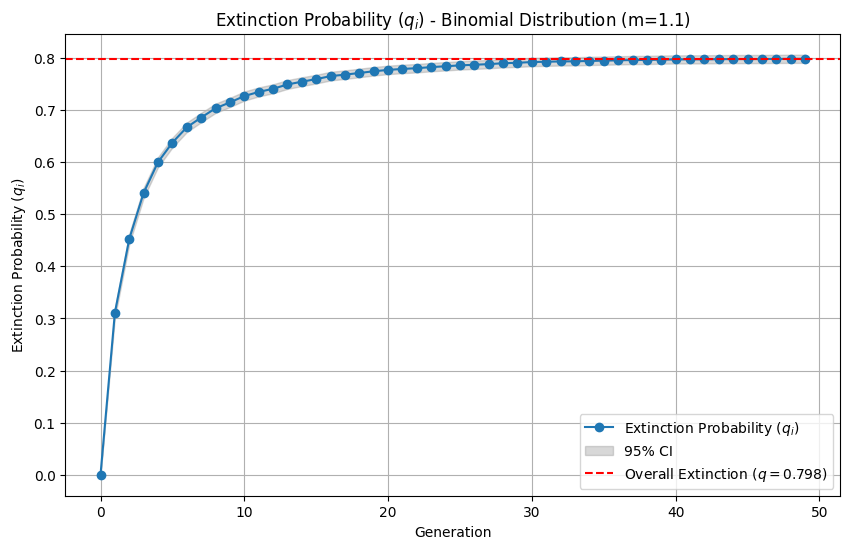

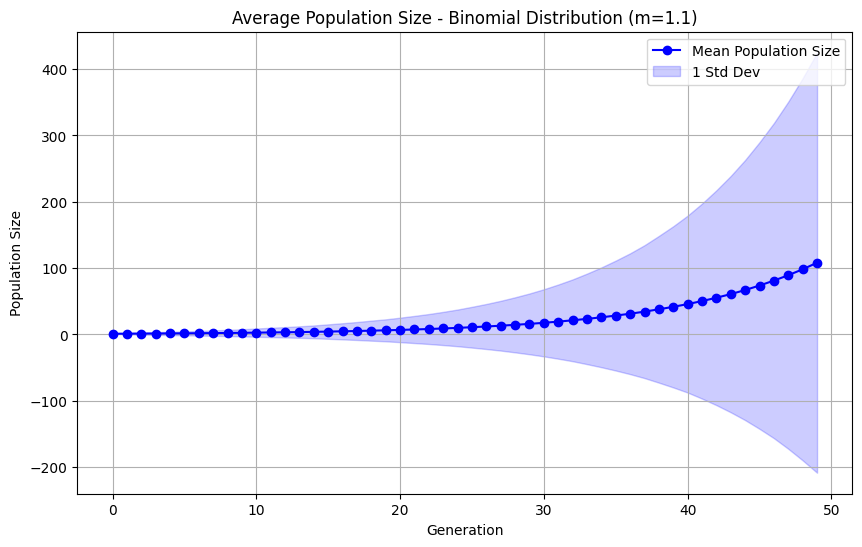

Simulating: Distribution=geometric, m=1.05
q (Overall Extinction Probability): 1.0
CI for q: (1.0, 1.0)


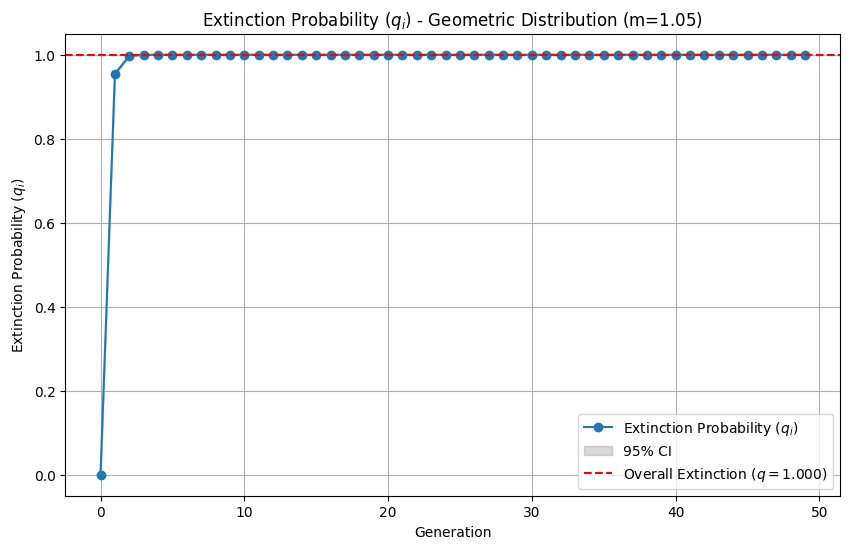

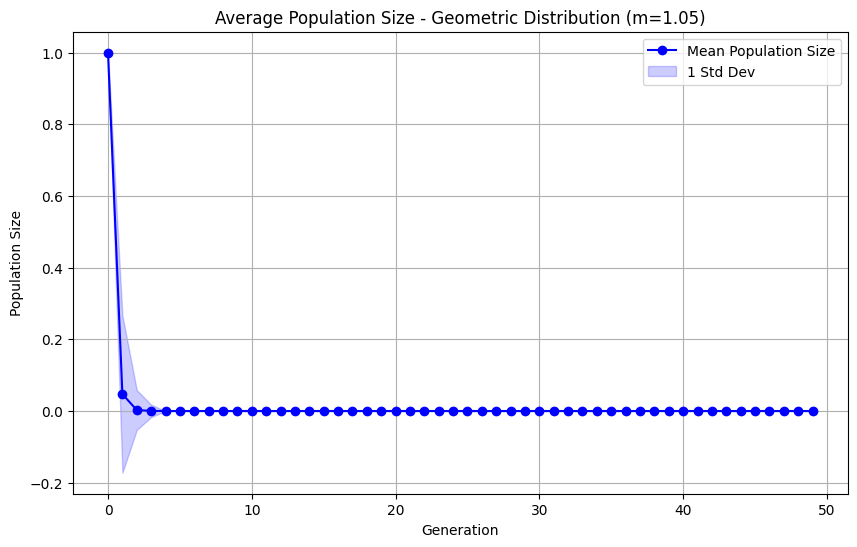

Simulating: Distribution=geometric, m=1.1
q (Overall Extinction Probability): 1.0
CI for q: (1.0, 1.0)


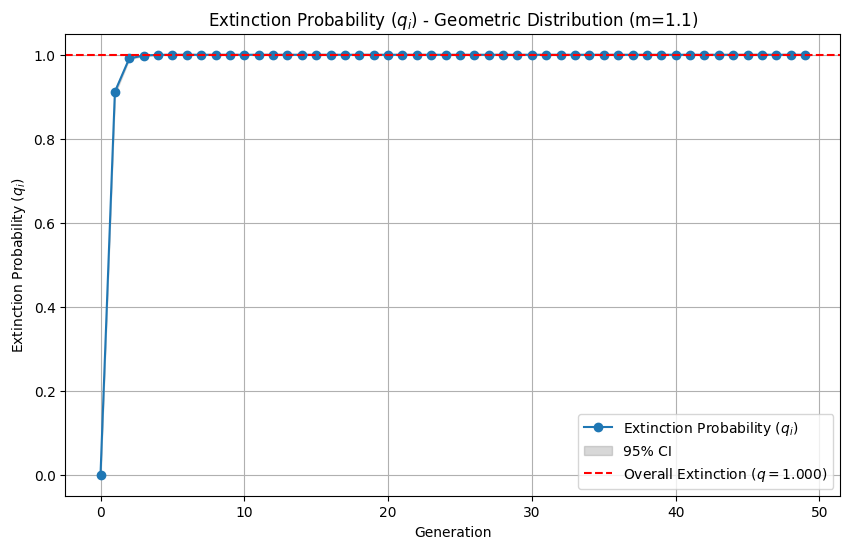

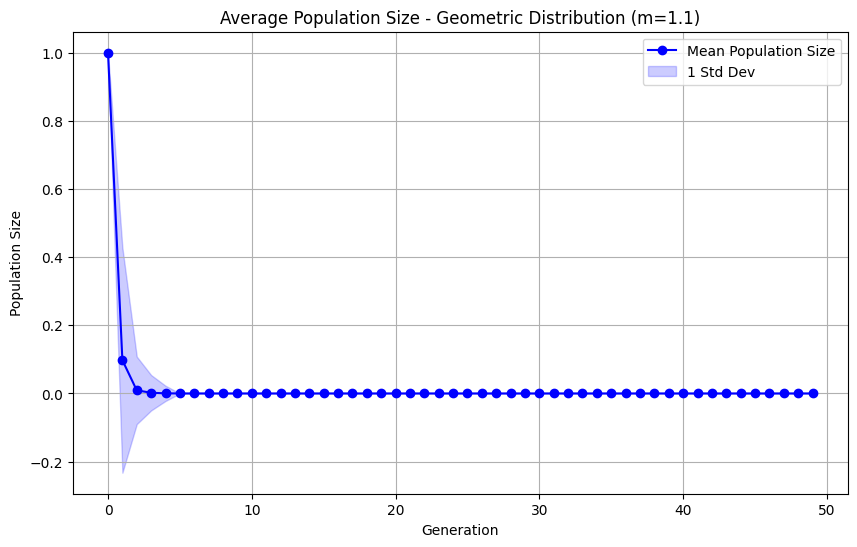

In [19]:
import numpy as np
from scipy.stats import poisson, binom, geom, norm
import matplotlib.pyplot as plt

def galton_watson_simulation(Y_v, m, N=10000, max_generations=50):
    """
    Simulate the Galton-Watson process for extinction probabilities and population sizes.
    """
    def sample_offspring(Y_v, m):
        if Y_v == "poisson":
            return np.random.poisson(m)
        elif Y_v == "binomial":
            return np.random.binomial(10, m / 10)
        elif Y_v == "geometric":
            return np.random.geometric(1 / m) - 1  # Zero-indexed
        else:
            raise ValueError("Unsupported offspring distribution")
    
    extinction_counts = np.zeros(max_generations)
    population_sizes = np.zeros((N, max_generations))
    
    for sim in range(N):
        Z = 1  # Start with one ancestor
        for gen in range(max_generations):
            population_sizes[sim, gen] = Z
            if Z == 0:
                extinction_counts[gen:] += 1
                break
            Z = sum(sample_offspring(Y_v, m) for _ in range(int(Z)))
    
    # Estimate q_i and q
    qi = extinction_counts / N
    q = qi[-1]
    
    # Compute confidence intervals
    z = norm.ppf(0.975)  # 95% CI
    ci = [
        (q_gen - z * np.sqrt(q_gen * (1 - q_gen) / N),
         q_gen + z * np.sqrt(q_gen * (1 - q_gen) / N)) 
        for q_gen in qi
    ]
    
    return qi, q, ci, population_sizes

def plot_extinction(qi, ci, Y_v, m):
    """
    Plot extinction probabilities and confidence intervals.
    """
    generations = np.arange(len(qi))
    lower_ci = [c[0] for c in ci]
    upper_ci = [c[1] for c in ci]
    
    plt.figure(figsize=(10, 6))
    plt.plot(generations, qi, label="Extinction Probability ($q_i$)", marker='o')
    plt.fill_between(generations, lower_ci, upper_ci, color='gray', alpha=0.3, label="95% CI")
    plt.axhline(qi[-1], color='red', linestyle='--', label=f"Overall Extinction ($q = {qi[-1]:.3f}$)")
    plt.title(f"Extinction Probability ($q_i$) - {Y_v.capitalize()} Distribution (m={m})")
    plt.xlabel("Generation")
    plt.ylabel("Extinction Probability ($q_i$)")
    plt.legend()
    plt.grid()
    plt.show()

def plot_population_size(population_sizes, Y_v, m):
    """
    Plot the average population size and standard deviation over generations.
    """
    mean_population = np.mean(population_sizes, axis=0)
    std_population = np.std(population_sizes, axis=0)
    generations = np.arange(len(mean_population))
    
    plt.figure(figsize=(10, 6))
    plt.plot(generations, mean_population, label="Mean Population Size", color="blue", marker='o')
    plt.fill_between(
        generations, 
        mean_population - std_population, 
        mean_population + std_population, 
        color="blue", 
        alpha=0.2, 
        label="1 Std Dev"
    )
    plt.title(f"Average Population Size - {Y_v.capitalize()} Distribution (m={m})")
    plt.xlabel("Generation")
    plt.ylabel("Population Size")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage with both plots
Y_v_list = ["poisson", "binomial", "geometric"]
m_values = [1.05, 1.1]

for Y_v in Y_v_list:
    for m in m_values:
        print(f"Simulating: Distribution={Y_v}, m={m}")
        qi, q, ci, population_sizes = galton_watson_simulation(Y_v, m, N=10000, max_generations=50)
        print(f"q (Overall Extinction Probability): {q}")
        print(f"CI for q: {ci[-1]}")
        
        # Extinction Probability Plot
        plot_extinction(qi, ci, Y_v, m)
        
        # Population Size Plot
        plot_population_size(population_sizes, Y_v, m)


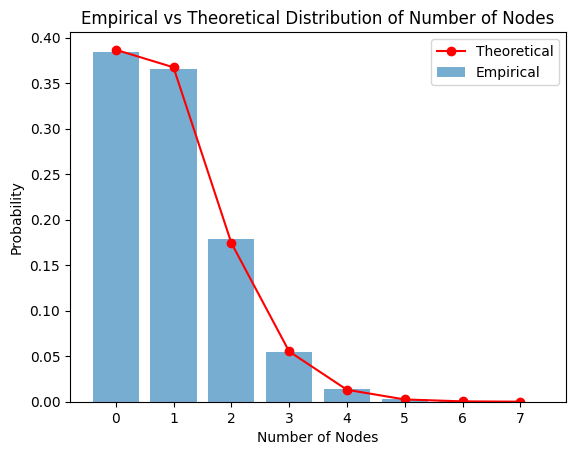

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
7.104924026400673e-06

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, chisquare

# Parameters
m = 0.95
num_samples = 10000

# Generate empirical distribution
samples = np.random.poisson(m, num_samples)
unique, counts = np.unique(samples, return_counts=True)
empirical_distribution = counts / num_samples

# Calculate theoretical distribution
max_nodes = unique[-1]
theoretical_distribution = poisson.pmf(unique, m)

# Plot empirical vs theoretical distribution
plt.bar(unique, empirical_distribution, alpha=0.6, label='Empirical')
plt.plot(unique, theoretical_distribution, 'ro-', label='Theoretical')
plt.xlabel('Number of Nodes')
plt.ylabel('Probability')
plt.legend()
plt.title('Empirical vs Theoretical Distribution of Number of Nodes')
plt.show()

# Chi-square test
chi2_stat, p_value = chisquare(counts, f_exp=theoretical_distribution * num_samples)
print(f'Chi-square statistic: {chi2_stat}, p-value: {p_value}')